## Run the Self-Organizing Map
___

First, load the data

In [1]:
from astropy.io import fits
from astropy.table import Table

import numpy as np

In [2]:
#Load in data produced in primary_targeting_region.ipynb
cut_data_file = '/data2/lsajkov/mpdg/data_products/GAMA/GAMA_primtarg_snr100_lms6_12_03jul2024.fits'

with fits.open(cut_data_file) as cat:
    GAMA_vect_data = Table(cat[1].data)

GAMA_vect_data.add_column(GAMA_vect_data['r_mag_err'], index = 4, name = 'surf_bright_r_err')

In [3]:
#Load in data
data_file = '/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_training_catalog_08Jul24.fits'

with fits.open(data_file) as cat:
    input_catalog_complete = Table(cat[1].data)

In [4]:
#Select the needed data
input_data = input_catalog_complete['gr_col', 'ug_col', 'ri_col']#, 'ur_col']
input_stds = input_catalog_complete['gr_col_err', 'ug_col_err', 'ri_col_err']#, 'ur_col_err']

input_labels = input_catalog_complete['gr_col', 'ug_col', 'ri_col', 'log_mstar', 'redshift']
input_label_stds = input_catalog_complete['gr_col_err', 'ug_col_err', 'ri_col_err']

tuple_labels = input_labels.as_array()
list_labels = [list(values) for values in tuple_labels]
input_labels = np.array(list_labels)

print(f'Len of input data: {len(input_data)}')

Len of input data: 49774


___

Initialize the SOM

In [5]:
from mpdg_som import SelfOrganizingMap

In [6]:
#Set parameters
name = 'mass_profile_dwarf_galaxies' #name of the SOM

mapsize   = [32, 32] #size of the map. pass as a list of dimensions OR as an integer (also pass number of dimensions)
dimension = None

initialization         = 'pca' #random or pca (principal component analysis)
termination            = 'either' #when to stop learning. maximum_steps = stop when maximum_steps have elapsed. error_thresh = stop when the error is below this threshold. either = stop when either condition is fulfilled
learning_rate_function = 'power_law' #which learning rate function to use. currently implemented: power_law
neighborhood_function  = 'gaussian' #which neighborhood function to use. currently implemented: gaussian
error_estimator        = 'quantization_error' #which error estimation function to use. currently implemented: max_misalignment

learning_rate = 0.65 #used to adjust the learning rate function
kernel_spread = 10 #used to adjust the neighborhood function
maximum_steps = 20 #used to adjust the learning rate and neighborhood functions
error_thresh  = 0.01 #used to stop the SOM if termination = 'error thresh'

In [7]:
#Declare the SOM
SOM = SelfOrganizingMap(
    name                   = name,
    mapsize                = mapsize,
    dimension              = dimension,
    initialization         = initialization,
    termination            = termination,
    learning_rate_function = learning_rate_function,
    neighborhood_function  = neighborhood_function,
    error_estimator        = error_estimator,
    learning_rate          = learning_rate,
    kernel_spread          = kernel_spread,
    maximum_steps          = maximum_steps,
    error_thresh           = error_thresh
)

In [10]:
data_cut = 40000 #use up to this much of the data (-1 for entire dataset)
randomized_idx = np.arange(0, len(input_data))
np.random.shuffle(randomized_idx)
randomized_idx = randomized_idx[:data_cut]

SOM.load_data(input_data[randomized_idx],
              variable_names = ['g-r', 'u-g', 'r-i'])#, 'u-r'])
SOM.normalize_data()

SOM.load_standard_deviations(input_stds[randomized_idx])
SOM.normalize_standard_deviations()

SOM.data_statistics()

| Data statistics 
total entries: 40000

stat	g-r	u-g	r-i	
min	0.000	0.000	0.000	
max	1.000	1.000	1.000	
mean	0.825	0.586	0.454	
median	0.836	0.591	0.455	
std	0.063	0.056	0.029	

In [14]:
#Initialize the SOM
SOM.build_SOM()


| SOM. Step 0. Initialization: pca
| Initial quantization error: 1.048


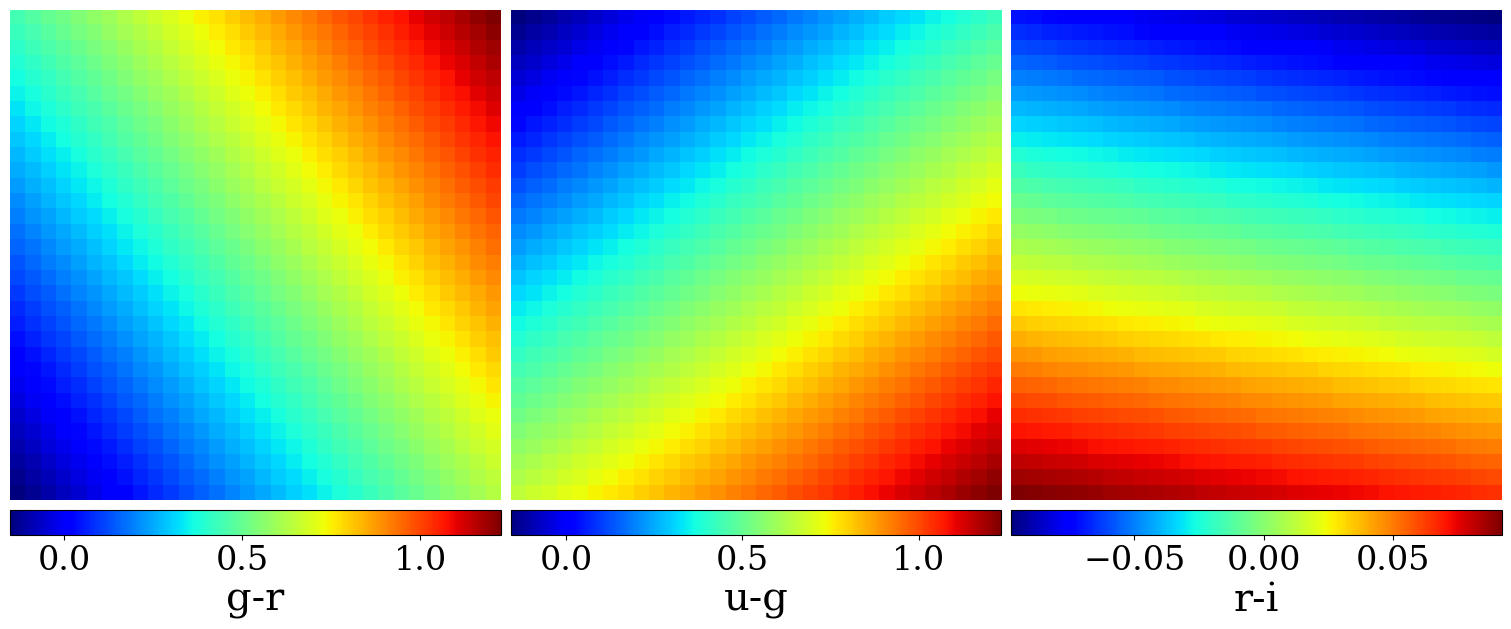

In [15]:
#Visualize SOM before training
SOM.show_map(cmap = 'jet')

#Look at initial quantization error
from mpdg_som_utils import SOM_ErrorEstimators

initial_quant_error = SOM_ErrorEstimators.quantization_error(SOM.weights_map,
                                                             SOM.data,
                                                             SOM.bmu_indices)
print(f'| Initial quantization error: {initial_quant_error:.3f}')

In [16]:
#Train the som
SOM.train()

Step 1 complete. Error: 0.124                                   
Step 2 complete. Error: 0.126                                   
Step 3 complete. Error: 0.117                                   
Step 4 complete. Error: 0.113                                   
Step 5 complete. Error: 0.119                                   


KeyboardInterrupt: 


| SOM. Step 5. Initialization: pca


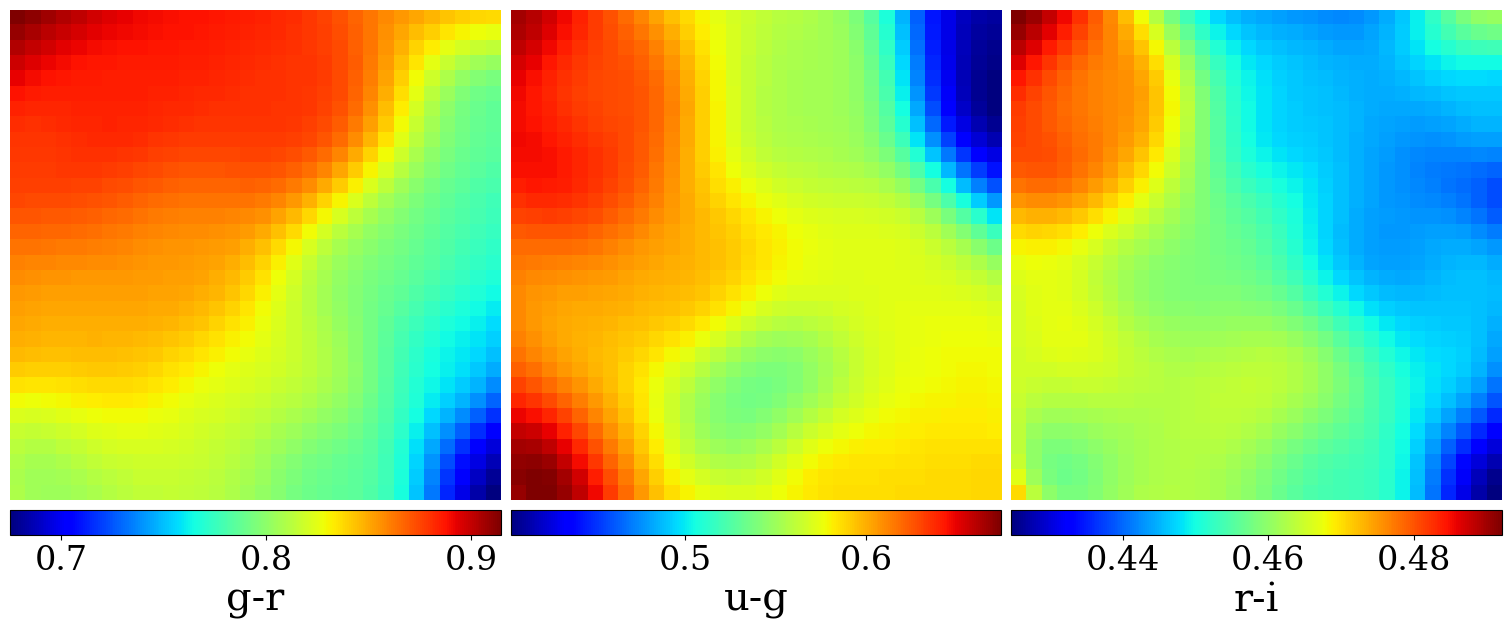

In [17]:
#Visualize the SOM after training
SOM.show_map(cmap = 'jet')

In [ ]:
#Load trained map instead


In [ ]:
len(input_labels[-int(data_cut):])

In [ ]:
iteration_map = np.nditer(np.full(SOM.mapsize, 0), flags = ['multi_index'])
for _ in iteration_map:
    for i in range(SOM.labels_dim):
        if np.sum(SOM.labeled_map[*iteration_map.multi_index][i]) == 0.:
            SOM.labeled_map[*iteration_map.multi_index][i] = np.full(SOM.pdr, np.nan)


| SOM. Step 5. Initialization: pca


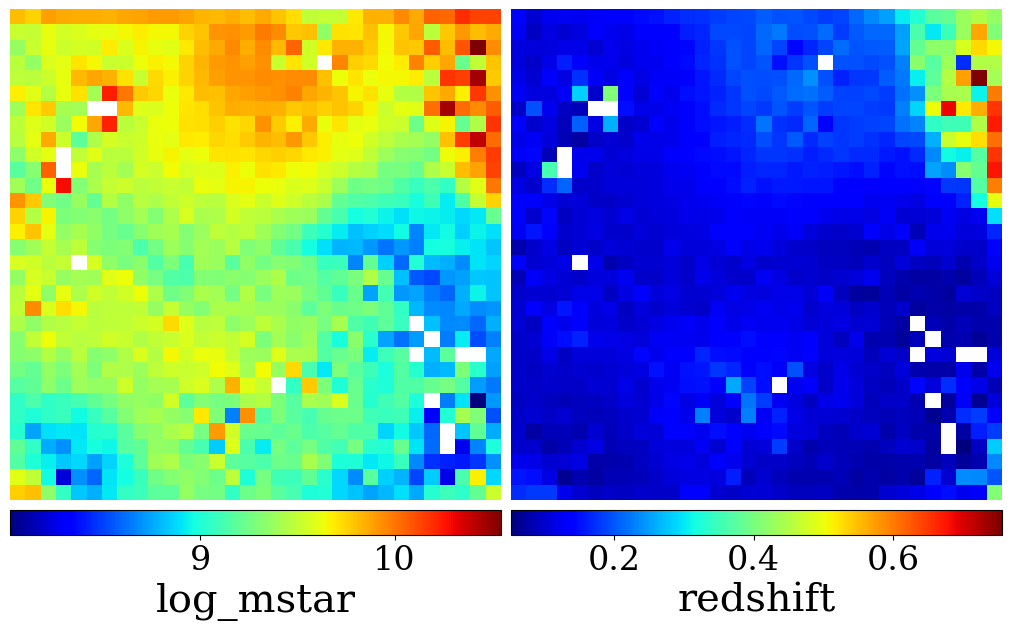

In [24]:
#Label the cells in the map with external parameters. Visualize the labeled map.
# SOM.load_labeling_data(input_labels[-int(data_cut):],
SOM.load_labeling_data(input_labels,
                       parameter_names = ['log_mstar', 'redshift'])
SOM.normalize_labeling_data()

SOM.label_map()

SOM.show_map(show_labeled = True,
             cmap = 'jet')

In [ ]:
#Find occupancy of cells:
cell_histogram = np.full(np.product(SOM.mapsize), np.nan)
for i, cell in enumerate(np.unique(SOM.bmu_indices, axis = 0)):
    cell_histogram[i] = np.sum(np.all(SOM.bmu_indices == cell, axis = -1))

print(f'The median occupancy of an occupied cell is: {np.nanmedian(cell_histogram)}')

In [25]:
# SOM.predict(SOM.data)
SOM.predict(SOM.labeling_data[:, :3])

/data2/lsajkov/mpdg/strw_mpdg/mpdg_som.py:477: RuntimeWarning: invalid value encountered in sqrt
  prediction_sigmas[index] = np.sqrt(np.sum(self.distribution_xs ** 2 * self.labeled_map[*bmu_coords], axis = -1) -\


In [40]:
np.sqrt(np.sum((SOM.labeling_data[:, 3:] - SOM.prediction_results) ** 2, axis = 0)/len(SOM.labeling_data))

array([0.42882759, 0.08724805])

In [30]:
SOM.prediction_results

array([[9.01539843, 0.09547793],
       [9.69740527, 0.1490153 ],
       [8.81210835, 0.08079058],
       ...,
       [9.87841686, 0.14649699],
       [9.62929084, 0.17887776],
       [8.71328157, 0.10875502]])

In [ ]:
SOM.save_outputs('/data2/lsajkov/mpdg/saved_soms',
                 save_weights = True, save_parameters = True)

In [ ]:
np.save('/data2/lsajkov/mpdg/saved_soms/09Jul24/prediction_results',
        SOM.prediction_results, allow_pickle = True)

In [ ]:
np.save('/data2/lsajkov/mpdg/saved_soms/09Jul24/labeling_data',
        SOM.labeling_data, allow_pickle = True)

___

Compare predictions to inputs

In [26]:
import matplotlib.pyplot as plt

<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_3623895/3476955548.py:23: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
/var/tmp/lsajkov/ipykernel_3623895/3476955548.py:24: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_3623895/3476955548.py:28: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


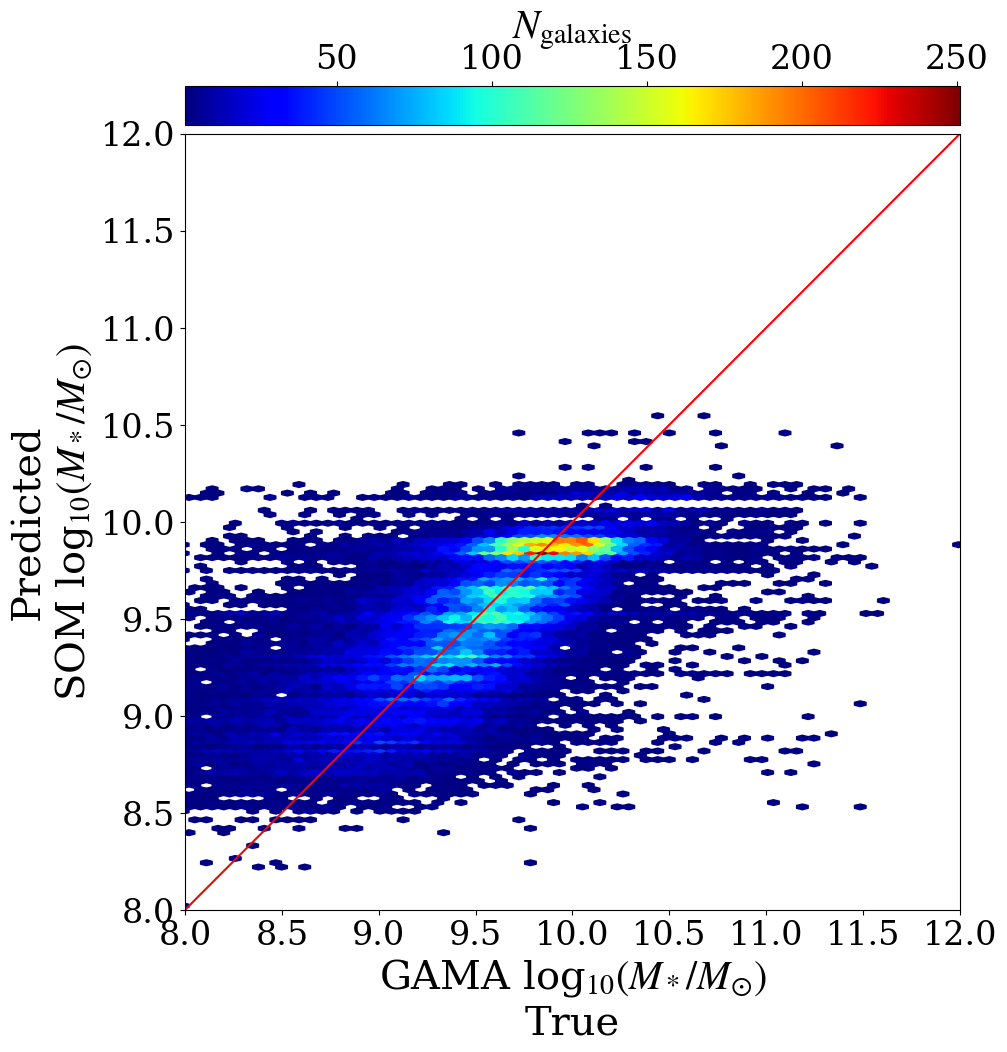

In [27]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim],
               SOM.prediction_results[:, 0],
               mincnt = 1, cmap = 'jet')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim][lo_stripe_idx],
#            SOM.prediction_results[:, 0][lo_stripe_idx],
#            color = 'green', s = 50, facecolor = 'none')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim][hi_stripe_idx],
#            SOM.prediction_results[:, 0][hi_stripe_idx],
#            color = 'red', s = 50, facecolor = 'none')

ax.axline([10, 10], slope = 1, color = 'red')

ax.set_xlim(8, 12)
ax.set_ylim(8, 12)
ax.set_xticks(np.arange(8, 12.5, 0.5))

ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_3623895/1264275842.py:27: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


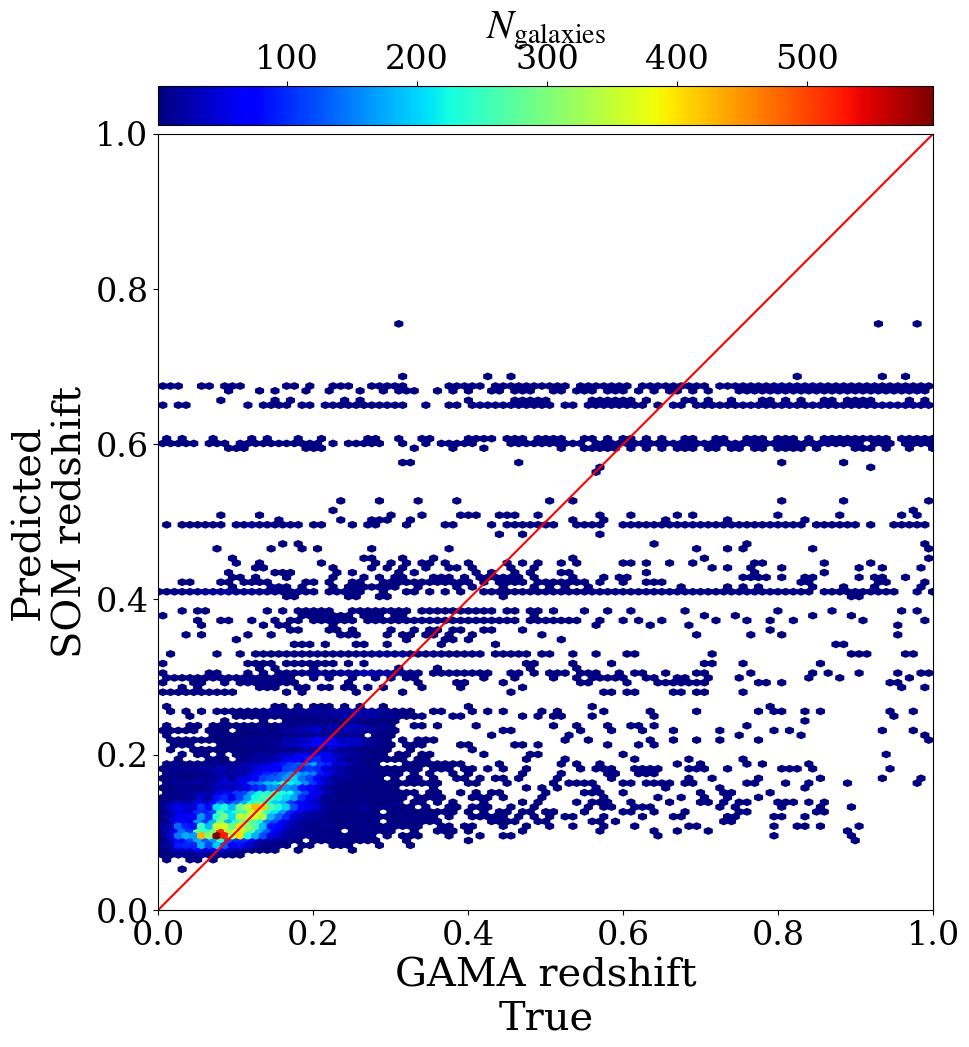

In [29]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim + 1],
               SOM.prediction_results[:, 1],
               mincnt = 1, cmap = 'jet')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim + 1][lo_stripe_idx],
#            SOM.prediction_results[:, 1][lo_stripe_idx],
#            color = 'green', s = 50, facecolor = 'none')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim + 1][hi_stripe_idx],
#            SOM.prediction_results[:, 1][hi_stripe_idx],
#            color = 'red', s = 50, facecolor = 'none')

ax.axline([0, 0], slope = 1, color = 'red')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('GAMA redshift\nTrue')
ax.set_ylabel('Predicted\nSOM redshift')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

In [ ]:
SOM_zs = SOM.prediction_results[:, 1]

lo_stripe_idx = (SOM_zs < 0.4) & (SOM_zs > 0.35)
hi_stripe_idx = (SOM_zs < 0.6) & (SOM_zs > 0.5)

hi_stripe_r_mag = input_catalog_complete[-int(data_cut/2):][hi_stripe_idx]['r_mag']
lo_stripe_r_mag = input_catalog_complete[-int(data_cut/2):][lo_stripe_idx]['r_mag']

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(lo_stripe_r_mag, bins = 'auto',
        histtype = 'step', color = 'green', linewidth = 5)

ax.set_xlabel('$r$-magnitude')

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(hi_stripe_r_mag, bins = 'auto',
        histtype = 'step', color = 'red', linewidth = 5)

ax.set_xlabel('$r$-magnitude')